In [2]:
import sys
import os
import pandas as pd

sys.path.append("src")

from train_autoencoder import train_autoencoder
from cluster_latents import extract_latents, cluster_and_visualize
from save_latents import extract_and_save_latents

In [3]:
train_autoencoder(
    dataset_path="preprocessed_dataset.npy",
    save_path="autoencoder.pth",
    epochs=30,
    batch_size=64,
    lr=1e-3
)

Epoch 1/30, Loss: 0.0352
Epoch 2/30, Loss: 0.0083
Epoch 3/30, Loss: 0.0072
Epoch 4/30, Loss: 0.0066
Epoch 5/30, Loss: 0.0062
Epoch 6/30, Loss: 0.0057
Epoch 7/30, Loss: 0.0055
Epoch 8/30, Loss: 0.0053
Epoch 9/30, Loss: 0.0052
Epoch 10/30, Loss: 0.0051
Epoch 11/30, Loss: 0.0050
Epoch 12/30, Loss: 0.0048
Epoch 13/30, Loss: 0.0047
Epoch 14/30, Loss: 0.0047
Epoch 15/30, Loss: 0.0046
Epoch 16/30, Loss: 0.0045
Epoch 17/30, Loss: 0.0044
Epoch 18/30, Loss: 0.0044
Epoch 19/30, Loss: 0.0043
Epoch 20/30, Loss: 0.0042
Epoch 21/30, Loss: 0.0042
Epoch 22/30, Loss: 0.0041
Epoch 23/30, Loss: 0.0040
Epoch 24/30, Loss: 0.0040
Epoch 25/30, Loss: 0.0039
Epoch 26/30, Loss: 0.0039
Epoch 27/30, Loss: 0.0039
Epoch 28/30, Loss: 0.0038
Epoch 29/30, Loss: 0.0037
Epoch 30/30, Loss: 0.0037
✅ Autoencoder saved to autoencoder.pth


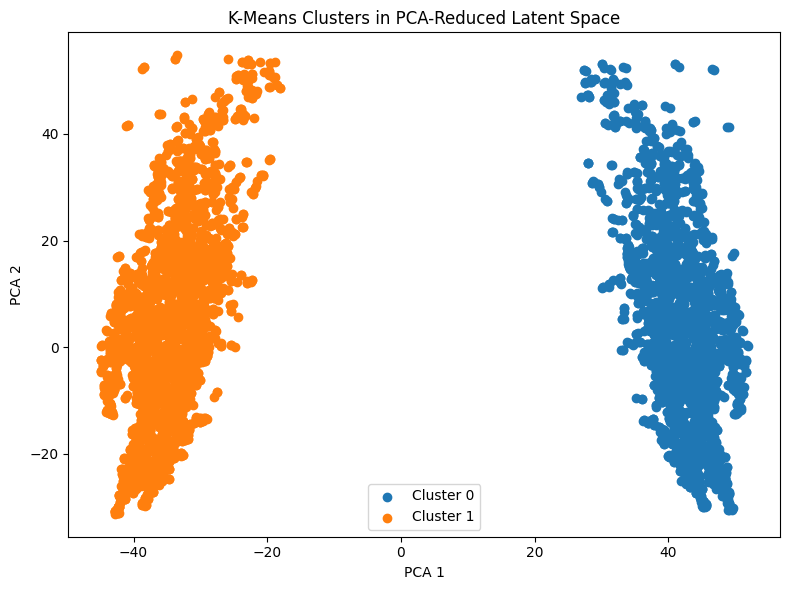

In [4]:
latents = extract_latents("autoencoder.pth", "preprocessed_dataset.npy")
labels = cluster_and_visualize(latents, n_clusters=2)

In [5]:
import numpy as np

np.save("cluster_labels.npy", labels)
print("✅ Cluster labels saved as cluster_labels.npy")

✅ Cluster labels saved as cluster_labels.npy


In [ ]:
from glob import glob
from pathlib import Path
from tqdm import tqdm
import shutil

image_paths = sorted(glob("**/*.tif", recursive=True))  # Adjust extension if needed

if not image_paths:
    raise ValueError("No .tif files found in the specified directory. Check the path or file extension.")

output_dir = "data/clustered_images/dibas"
os.makedirs(output_dir, exist_ok=True)

for i, label in enumerate(labels):
    cluster_folder = os.path.join(output_dir, f"cluster_{label}")
    os.makedirs(cluster_folder, exist_ok=True)
    print()
    src = image_paths[i]
    dst = os.path.join(cluster_folder, Path(src).name)
    shutil.copy2(src, dst)

print(f"✅ Images copied into {output_dir}/cluster_*/")

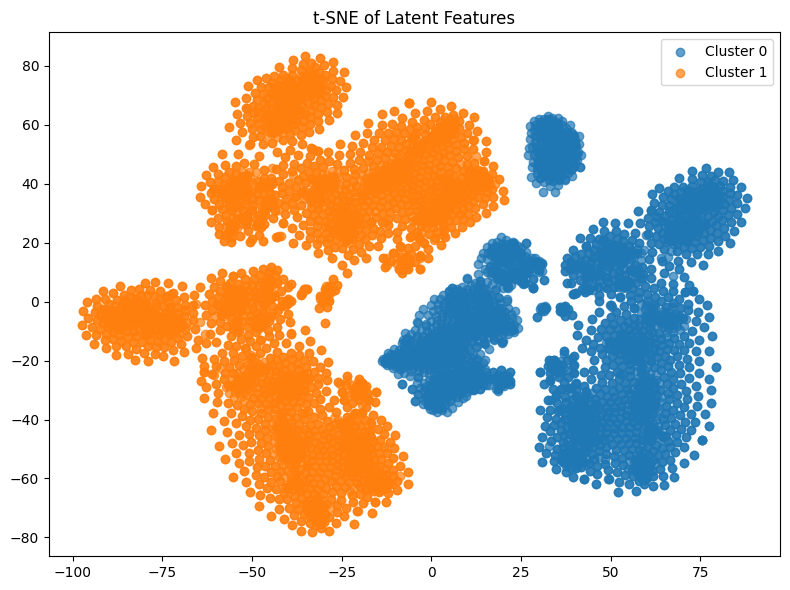

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(latents)

plt.figure(figsize=(8, 6))
for i in range(np.max(labels)+1):
    plt.scatter(tsne_result[labels == i, 0], tsne_result[labels == i, 1], label=f"Cluster {i}", alpha=0.7)
plt.title("t-SNE of Latent Features")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
extract_and_save_latents("preprocessed_dataset.npy", "autoencoder.pth")

✅ Latents saved to latents.npy (shape: (7579, 16384))


In [1]:
import sys
sys.path.append("src")

from torch.utils.data import TensorDataset, DataLoader
from evaluate_unsupervised import evaluate_unsupervised
import numpy as np
import torch

# Load and prepare image data
data = torch.tensor(np.load("preprocessed_dataset.npy"), dtype=torch.float32).permute(0, 3, 1, 2)
dataset = torch.utils.data.TensorDataset(data)

# Split into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Evaluate
evaluate_unsupervised(
    latents_path="latents.npy",
    cluster_labels_path="cluster_labels.npy",
    train_loader=train_loader,
    val_loader=val_loader,
    model_weights_path="autoencoder.pth"
)


✅ Evaluation complete. Metrics saved to unsupervised_evaluation.json


{'silhouette_score': 0.4102168381214142,
 'train_reconstruction_loss': 0.003625812820207916,
 'val_reconstruction_loss': 0.003714307958337789,
 'generalization_gap': 8.849513812987306e-05}